In [2]:
from elevation.prediction_pipeline import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats
import azimuth.util

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [ ]:
np.random.seed(1234)
learn_options = {'num_proc': 10,
                 'nuc_features_WT': False, 'include_pi_nuc_feat': False,
                     'mutation_type' : False,
                     'mutation_details' : False,
                     'annotation_onehot' : False, #featurize like CFD
                     'annotation_decoupled_onehot' : True, #decouple the CFD features into letters and position
                     "include_Tm": False,
                     'include_azimuth_score': None, # all of them ["WT","MUT","DELTA"]
                     'azimuth_feat' : None,#["MUT", "WT"],
                     "include_gene_position": False,
                     "cv": "stratified",
                     'adaboost_loss' : 'ls',
                     'adaboost_CV': False, "algorithm_hyperparam_search" : "grid",
                     'n_folds' : 10,
                     'allowed_category' : None,#"Mismatch",#"Insertion",
                     "include_NGGX_interaction": False,
                     'normalize_features' : False, 'class_weight': None,
                     "phen_transform": 'kde_cdf',
                     "training_metric": 'spearmanr',
                     "skip_pam_feat" : True, "letpos_indep_ft": False, "letpos_inter_ft": True,
                     "fit_intercept" : True,
                     "seed" : 12345,
                     "num_proc": 1,
                     "alpha": np.array([1.0e-3]),
                     "V": "CD33",
                     "left_right_guide_ind": [4,26,30],
                     "order": 2,
                     "testing_non_binary_target_name": 'ranks',
                     'stack model': 'GP',
                     'models': ['AdaBoost'],
                     }

In [ ]:
base_model, _ = train_base_model(learn_options)
guideseq_data = load_guideseq(learn_options)
preds = predict_guideseq(base_model, guideseq_data, learn_options)
stacker_preds, naive_preds, cfd_preds, y_all, r_naive, r_stacker =  cross_validate_guideseq(guideseq_data, preds, learn_options)

In [8]:
truth, mism = y_all

In [11]:
%matplotlib inline

In [ ]:
plt.figure();
plt.title('#Mismatches vs truth (sanity check)')
plt.plot(mism, truth, 'o', alpha=0.5)

In [6]:
def get_corr_by_mismatches(pred, truth, mism, cfd_pred=None):
    results = []
    sorted_mism = np.sort(np.unique(mism))
    for m in sorted_mism:
        if m == 1:
            continue
        pred_sub = pred[mism==m]
        truth_sub = truth[mism==m]
        corr = sp.stats.spearmanr(pred_sub, truth_sub)[0]
        # corr = azimuth.util.get_pval_from_predictions(cfd_pred[mism==m], pred_sub, truth_sub, twotailed=False, method='steiger')[1]
        # corr = -np.log10(pv)
        results.append([m, corr, (mism==m).sum()])
    return np.array(results)

In [ ]:
naive_res = get_corr_by_mismatches(naive_preds, truth, mism)
stacker_res = get_corr_by_mismatches(stacker_preds, truth, mism)
cfd_res = get_corr_by_mismatches(cfd_preds, truth, mism)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(cfd_res[:,0], cfd_res[:,1], 'o-r', label='CFD')
plt.plot(naive_res[:,0], naive_res[:,1], 'o-g', label='naive')
# plt.plot(stacker_res[:,0], stacker_res[:,1], 'o-b', label='stacker')
plt.legend(loc=0)
plt.xlabel('#mismatches')
plt.ylabel('Spearman')
plt.xlim((2, 6))

In [ ]:
plt.figure();
plt.plot(cfd_res[:,0], cfd_res[:, 2], 'o-')
plt.xlabel("#mismatches")
plt.ylabel('#guides')

In [ ]:
print("CFD: %.4f" % sp.stats.spearmanr(cfd_preds, truth)[0])
print("Naive: %.4f" % sp.stats.spearmanr(naive_preds, truth)[0])
#sp.stats.spearmanr(stacker_preds, truth)[0]

In [ ]:
naive_res

In [ ]:
cfd_res

In [ ]:
plt.figure()
plt.plot(cfd_res[:,1], naive_res[:,1],'o')
plt.plot([-1, 1], [-1,1], 'k-')

In [ ]:
t2_stack, pv_stack, corr0_stack, corr1_stack, corr01_stack = azimuth.util.get_pval_from_predictions(naive_preds, 
                                                                                            cfd_preds,  
                                                                                            truth, twotailed=False, 
                                                                                            method='steiger')

In [ ]:
pv_stack

In [ ]:
t2_stack, pv_stack, corr0_stack, corr1_stack, corr01_stack = azimuth.util.get_pval_from_predictions(stacker_preds, 
                                                                                            cfd_preds,  
                                                                                            truth, twotailed=False, 
                                                                                            method='steiger')

In [ ]:
pv_stack

In [ ]:
naive_res = get_corr_by_mismatches(naive_preds, truth, mism, cfd_preds)

In [ ]:
naive_res

In [ ]:
plt.figure(figsize=[10, 10])
plt.plot([0,1], [0,1], 'k-')
plt.scatter(cfd_preds, naive_preds, c=mism)
plt.xlabel('CFD')
plt.ylabel('Naive')

In [ ]:
plt.figure()
plt.hist(np.log(truth), bins=20)

In [ ]:
plt.figure(figsize=[10, 10])
plt.plot([0,1], [0,1], 'k-')
plt.scatter(cfd_preds*0.468, naive_preds, c=mism)
plt.xlabel('CFD')
plt.ylabel('Naive')

In [15]:
from elevation.nicolo import *

In [16]:
Y, f, l = get_offtarget_data(feature_order=1)

MKL not available, so I'm not adjusting the number of threads
Launching 1 jobs with 1 MKL threads each
loading processed data from file: ../../data/offtarget/CD33.processed.[4, 26, 30].pamfiltTrue.p...
done.
featurizing data...
found 4853 rows and 11 feature colums to azimut_featurize
Constructing features...
		constructing order 1 features
							done
		Elapsed time for constructing features is 4.43 seconds
done.


In [17]:
(Y['Day21-ETP'] >= 1.).sum()/float(Y.shape[0])

0.46837008036266226

In [ ]:
plt.figure(figsize=[10, 6])
plt.plot(mism, cfd_preds, 'o', alpha=.5)
# plt.hexbin(mism, np.log(cfd_preds))
plt.xlabel('#mismatches')
plt.ylabel('CFD prediction')
plt.title("#M vs CFD (rho=%.4f)" % sp.stats.spearmanr(mism, cfd_preds)[0])

In [ ]:
plt.figure(figsize=[10, 6])
plt.plot(mism, naive_preds, 'o', alpha=.5)
plt.xlabel('#mismatches')
plt.ylabel('Naive prediction')
plt.title("#M vs Naive (rho=%.4f)" % sp.stats.spearmanr(mism, naive_preds)[0])

In [ ]:
corr_cfd_preds = cfd_preds * np.power((Y['Day21-ETP'] >= 1.).sum()/float(Y.shape[0]), mism-1)

In [ ]:
plt.figure(figsize=[10, 10])
plt.plot([0,1], [0,1], 'k-')
plt.scatter(cfd_preds, corr_cfd_preds, c=mism)
plt.xlabel('CFD predictions')
plt.ylabel('Corrected CFD predictions')

In [ ]:
corr_naive_preds = naive_preds * np.power((Y['Day21-ETP'] >= 1.).sum()/float(Y.shape[0]), mism-1)[:, None]

In [ ]:
corr_cfd_res = get_corr_by_mismatches(corr_cfd_preds, truth, mism, cfd)
cfd_res = get_corr_by_mismatches(cfd_preds, truth, mism)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(cfd_res[:,0], cfd_res[:,1], 'o-r', label='CFD')
plt.plot(corr_cfd_res[:,0], corr_cfd_res[:,1], 'o-g', label='naive')
plt.plot(stacker_res[:,0], stacker_res[:,1], 'o-b', label='stacker')
plt.legend(loc=0)
plt.xlabel('#mismatches')
plt.ylabel('Spearman')
plt.xlim((2, 6))

In [ ]:
print("CFD: %.4f" % sp.stats.spearmanr(cfd_preds, truth)[0])
print("CFD-corrected: %.4f" % sp.stats.spearmanr(corr_cfd_preds, truth)[0])
print("Naive: %.4f" % sp.stats.spearmanr(naive_preds, truth)[0])
print("Naive-corrected: %.4f" % sp.stats.spearmanr(corr_naive_preds, truth)[0])

In [ ]:
plt.hist(f['annot'].sum(0).values, bins=20)

In [ ]:
p_x = 1./f['annot'].shape[1]

In [ ]:
corr_cfd_preds = cfd_preds * np.power((Y['Day21-ETP'] >= 1.).sum()/float(Y.shape[0]), mism-1) / np.power(p_x, mism)

In [ ]:
print("CFD-corrected: %.4f" % sp.stats.spearmanr(corr_cfd_preds, truth)[0])

In [3]:
np.random.seed(1234)
learn_options = {'num_proc': 10,
                 'nuc_features_WT': False, 'include_pi_nuc_feat': False,
                     'mutation_type' : False,
                     'mutation_details' : False,
                     'annotation_onehot' : False, #featurize like CFD
                     'annotation_decoupled_onehot' : True, #decouple the CFD features into letters and position
                     "include_Tm": False,
                     'include_azimuth_score': None, # all of them ["WT","MUT","DELTA"]
                     'azimuth_feat' : None,#["MUT", "WT"],
                     "include_gene_position": False,
                     "cv": "stratified",
                     'adaboost_loss' : 'ls',
                     'adaboost_CV': False, "algorithm_hyperparam_search" : "grid",
                     'n_folds' : 10,
                     'allowed_category' : None,#"Mismatch",#"Insertion",
                     "include_NGGX_interaction": False,
                     'normalize_features' : False, 'class_weight': None,
                     "phen_transform": 'Platt',
                     "training_metric": 'spearmanr',
                     "skip_pam_feat" : True, "letpos_indep_ft": False, "letpos_inter_ft": True,
                     "fit_intercept" : True,
                     "seed" : 12345,
                     "num_proc": 1,
                     "alpha": np.array([1.0e-3]),
                     "V": "CD33",
                     "left_right_guide_ind": [4,26,30],
                     "order": 2,
                     "testing_non_binary_target_name": 'ranks',
                     'stack model': 'GP',
                     'models': ['AdaBoost'],
                     'recompute':True
                     }

In [4]:
base_model, _ = train_base_model(learn_options)
guideseq_data = load_guideseq(learn_options)
preds = predict_guideseq(base_model, guideseq_data, learn_options)
stacker_preds, naive_preds, cfd_preds, y_all, r_naive, r_stacker =  cross_validate_guideseq(guideseq_data, preds, learn_options)

________________________________________________________________________________
[Memory] Calling elevation.prediction_pipeline.train_base_model-alias...
train_base_model-alias({ 'V': 'CD33',
  'adaboost_CV': False,
  'adaboost_loss': 'ls',
  'algorithm_hyperparam_search': 'grid',
  'allowed_category': None,
  'alpha': array([ 0.001]),
  'annotation_decoupled_onehot': True,
  'annotation_onehot': False,
  'azimuth_feat': None,
  'class_weight': None,
  'cv': 'stratified',
  'fit_intercept': True,
  'include_NGGX_interaction': False,
  'include_Tm': False,
  'include_azimuth_score': None,
  'include_gene_position': False,
  'include_pi_nuc_feat': False,
  'left_right_guide_ind': [4, 26, 30],
  'letpos_indep_ft': False,
  'letpos_inter_ft': True,
  'models': ['AdaBoost'],
  'mutation_details': False,
  'mutation_type': False,
  'n_folds': 10,
  'normalize_features': False,
  'nuc_features_WT': False,
  'num_proc': 1,
  'order': 2,
  'phen_transform': 'Platt',
  'recompute': True,
  'seed

 /home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


featurizing data...
done.
range of y_all is [0.000000, 1.000000]
filename = VCD33AdaBoostRegressor.order2Day21-ETP.gene.spearman
Cross-validating genes...
		RMSE:  0.393142382955
		Spearman correlation:  0.62439711932
		finished fold/gene 1 of 1
		median spearmanr across gene folds: 0.624
		Elapsed time for cv is 0.30 seconds
___________________________________________train_base_model-alias - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling elevation.prediction_pipeline.load_guideseq-alias...
load_guideseq-alias({ 'V': 'CD33',
  'adaboost_CV': False,
  'adaboost_loss': 'ls',
  'algorithm_hyperparam_search': 'grid',
  'allowed_category': None,
  'alpha': array([ 0.001]),
  'annotation_decoupled_onehot': True,
  'annotation_onehot': False,
  'azimuth_feat': None,
  'class_weight': None,
  'cv': 'stratified',
  'fit_intercept': True,
  'include_NGGX_interaction': False,
  'include_Tm': False,
  'include_azimuth_score': None,
  

 /home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 /home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning:The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=20.



[0, 0]: Spearman R for fold: 0.569 naive, 0.567 stacker, 0.440 CFD
[1, 0]: Spearman R for fold: 0.316 naive, 0.451 stacker, 0.317 CFD
[2, 0]: Spearman R for fold: 0.274 naive, 0.230 stacker, 0.394 CFD
[3, 0]: Spearman R for fold: 0.523 naive, 0.612 stacker, 0.603 CFD
[4, 0]: Spearman R for fold: 0.511 naive, 0.443 stacker, 0.260 CFD
[5, 0]: Spearman R for fold: 0.223 naive, 0.495 stacker, 0.208 CFD
[6, 0]: Spearman R for fold: 0.457 naive, 0.467 stacker, 0.562 CFD
[7, 0]: Spearman R for fold: 0.433 naive, 0.701 stacker, 0.459 CFD
[8, 0]: Spearman R for fold: 0.506 naive, 0.723 stacker, 0.412 CFD
[9, 0]: Spearman R for fold: 0.404 naive, 0.491 stacker, 0.273 CFD
[10, 0]: Spearman R for fold: 0.123 naive, 0.414 stacker, 0.221 CFD
[11, 0]: Spearman R for fold: 0.347 naive, 0.359 stacker, 0.185 CFD
[12, 0]: Spearman R for fold: 0.098 naive, 0.262 stacker, 0.241 CFD
[13, 0]: Spearman R for fold: 0.584 naive, 0.458 stacker, 0.296 CFD
[14, 0]: Spearman R for fold: 0.579 naive, 0.512 stacker,

In [9]:
naive_res = get_corr_by_mismatches(naive_preds, truth, mism)
stacker_res = get_corr_by_mismatches(stacker_preds, truth, mism)
cfd_res = get_corr_by_mismatches(cfd_preds, truth, mism)

(2, 6)

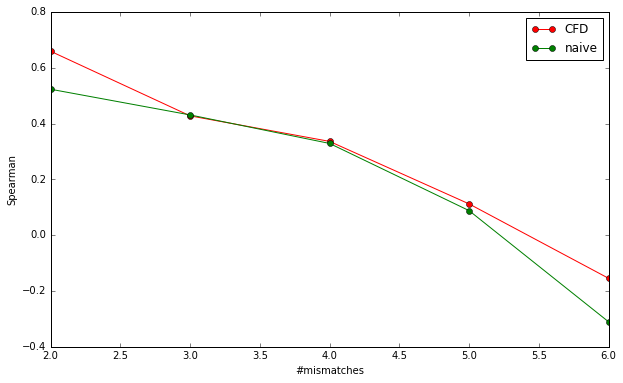

In [12]:
plt.figure(figsize=(10,6))
plt.plot(cfd_res[:,0], cfd_res[:,1], 'o-r', label='CFD')
plt.plot(naive_res[:,0], naive_res[:,1], 'o-g', label='naive')
# plt.plot(stacker_res[:,0], stacker_res[:,1], 'o-b', label='stacker')
plt.legend(loc=0)
plt.xlabel('#mismatches')
plt.ylabel('Spearman')
plt.xlim((2, 6))

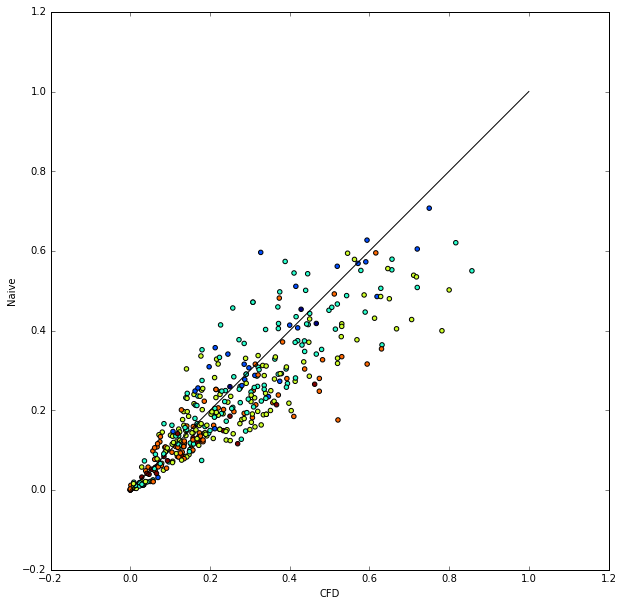

In [13]:
plt.figure(figsize=[10, 10])
plt.plot([0,1], [0,1], 'k-')
plt.scatter(cfd_preds, naive_preds, c=mism)
plt.xlabel('CFD')
plt.ylabel('Naive')

In [59]:
corr_cfd_preds = cfd_preds * np.power(0.5, mism-1)# np.power((Y['Day21-ETP'] >= 1.).sum()/float(Y.shape[0]), mism-1) 

In [60]:
corr_naive_preds = naive_preds.flatten() * np.power((Y['Day21-ETP'] >= 1.).sum()/float(Y.shape[0]), mism-1)

In [61]:
print("CFD: %.4f" % sp.stats.spearmanr(cfd_preds, truth)[0])
print("CFD-corrected: %.4f" % sp.stats.spearmanr(corr_cfd_preds, truth)[0])
print("Naive: %.4f" % sp.stats.spearmanr(naive_preds, truth)[0])
print("Naive-corrected: %.4f" % sp.stats.spearmanr(corr_naive_preds, truth)[0])

CFD: 0.3559
CFD-corrected: 0.4761
Naive: 0.3951
Naive-corrected: 0.4744


In [40]:
corr_cfd_preds

array([  2.3680506 ,   2.26472041,   1.45552022,   2.68625739,
         2.18488796,   0.45480649,   2.14516273,   3.28211813,
         0.61314652,   1.43429009,   1.55567356,   1.54765057,
         0.78031713,  10.82742081,   0.81634316,   5.80988689,
         2.45661829,   1.18719095,   3.60321393,   0.65121391,
         1.12621043,  10.35216209,   7.42881372,   1.32170616,
         0.42857143,   3.32127799,   1.96366042,   1.44912986,
         1.1708729 ,   0.33059384,   0.14826832,   0.14772908,
         2.67648775,   1.04194226,   0.82052953,   0.30318595,
         0.92895359,   1.8682037 ,   2.94787987,   3.30321354,
         2.02646951,   0.14572916,   0.58609252,   3.40034703,
         1.25751652,   2.34192678,   0.74015545,   1.35382939,
         3.12126852,   0.63543565,   1.49854052,   2.1479024 ,
         0.        ,   6.41208297,   1.3034843 ,   2.05883673,
         0.63493357,   3.28309368,   7.63714184,   0.77356319,
         1.35320723,   1.28686212,   1.38069873,   0.84

In [21]:
preds_corr = preds * (Y['Day21-ETP'] >= 1.).sum()/float(Y.shape[0])
stacker_preds_c, naive_preds_c, cfd_preds_c, y_all, r_naive, r_stacker =  cross_validate_guideseq(guideseq_data, preds_corr, learn_options)

[0, 0]: Spearman R for fold: 0.652 naive, 0.572 stacker, 0.440 CFD
[1, 0]: Spearman R for fold: 0.328 naive, 0.436 stacker, 0.317 CFD
[2, 0]: Spearman R for fold: 0.193 naive, 0.203 stacker, 0.394 CFD
[3, 0]: Spearman R for fold: 0.732 naive, 0.548 stacker, 0.603 CFD
[4, 0]: Spearman R for fold: 0.515 naive, 0.432 stacker, 0.260 CFD
[5, 0]: Spearman R for fold: 0.386 naive, 0.512 stacker, 0.208 CFD
[6, 0]: Spearman R for fold: 0.447 naive, 0.431 stacker, 0.562 CFD
[7, 0]: Spearman R for fold: 0.614 naive, 0.635 stacker, 0.459 CFD
[8, 0]: Spearman R for fold: 0.533 naive, 0.740 stacker, 0.412 CFD
[9, 0]: Spearman R for fold: 0.511 naive, 0.476 stacker, 0.273 CFD
[10, 0]: Spearman R for fold: 0.138 naive, 0.343 stacker, 0.221 CFD
[11, 0]: Spearman R for fold: 0.481 naive, 0.441 stacker, 0.185 CFD
[12, 0]: Spearman R for fold: 0.207 naive, 0.272 stacker, 0.241 CFD
[13, 0]: Spearman R for fold: 0.663 naive, 0.450 stacker, 0.296 CFD
[14, 0]: Spearman R for fold: 0.616 naive, 0.509 stacker, 

In [22]:
naive_res = get_corr_by_mismatches(naive_preds_c, truth, mism)
stacker_res = get_corr_by_mismatches(stacker_preds_c, truth, mism)
cfd_res = get_corr_by_mismatches(cfd_preds_c, truth, mism)

(2, 6)

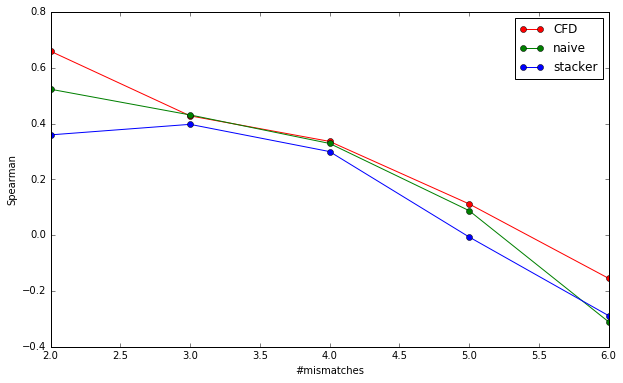

In [23]:
plt.figure(figsize=(10,6))
plt.plot(cfd_res[:,0], cfd_res[:,1], 'o-r', label='CFD')
plt.plot(naive_res[:,0], naive_res[:,1], 'o-g', label='naive')
plt.plot(stacker_res[:,0], stacker_res[:,1], 'o-b', label='stacker')
plt.legend(loc=0)
plt.xlabel('#mismatches')
plt.ylabel('Spearman')
plt.xlim((2, 6))

In [24]:
 (Y['Day21-ETP'] >= 1.).sum()/float(Y.shape[0])

0.46837008036266226